# Kimchi Momentum Strategy

In [1]:
%load_ext dotenv
%dotenv

# Fetch and verify Binance data

In [2]:
from binance.um_futures import UMFutures
import os
import json
from datetime import datetime, timezone

START_DATE = datetime(2020, 1,1)
END_DATE = datetime(2024, 1,1)

client = UMFutures(os.getenv("BINANCE_API_KEY"), os.getenv("BINANCE_SECRET_KEY"))

# https://binance-docs.github.io/apidocs/futures/en/#kline-candlestick-data
# https://developers.binance.com/docs/derivatives/usds-margined-futures/market-data/rest-api/Continuous-Contract-Kline-Candlestick-Data
# https://github.com/binance/binance-futures-connector-python/blob/main/binance/um_futures/market.py#L128

def date_to_binance(x):
    return int(datetime.timestamp(x)) * 1000
data = client.continuous_klines("BTCUSDT", "PERPETUAL", "1d", startTime=date_to_binance(START_DATE), endTime=date_to_binance(END_DATE), limit=1500)

print(len(data))
# close time / close price
print(datetime.fromtimestamp(data[0][6] / 1000, timezone.utc).strftime("%c"), data[0][4])
print(datetime.fromtimestamp(data[-1][6] / 1000, timezone.utc).strftime("%c"), data[-1][4])

ds1 = data

1461
Wed Jan  1 23:59:59 2020 7197.57
Sun Dec 31 23:59:59 2023 42314.00


# Fetch and verify Upbit data

In [3]:
import requests

def date_to_upbit(x):
    return x.strftime("%Y-%m-%d %H:%M:%S")

out_of_range_prefix = f"{START_DATE.year-1}-"
to_date = date_to_upbit(END_DATE)
results = []
while(True): 
    url = "https://id-api.upbit.com/v1/candles/days"
    params = {  
        'market': 'IDR-BTC',  
        'count': 200,
        'to': to_date
    }  
    headers = {"accept": "application/json"}
    
    response = requests.get(url, params=params, headers=headers)
    
    data = response.json()
    results += data

    if len(data) == 0:
        break

    to_date = data[-1]["candle_date_time_utc"]

    if out_of_range_prefix in to_date:
        break

results.reverse()
results = [x for x in results if out_of_range_prefix not in x["candle_date_time_utc"]]

print(len(results))
print(results[0]["candle_date_time_utc"], results[0]["prev_closing_price"] * 0.00007)
print(results[-1]["candle_date_time_utc"], results[-1]["prev_closing_price"] * 0.00007)

ds2 = results

1461
2020-01-01T00:00:00 7038.499999999999
2023-12-31T00:00:00 45770.899999999994


# Transform both datasets into ts/price dfs

In [4]:
import pandas as pd

df1 = pd.DataFrame(ds1)[[4, 5, 6]].rename(columns={4: "price", 5: "Volume", 6: "ts"})
df1["ts"] = pd.to_datetime(df1["ts"] - 1000 * 60 * 60 * 24 + 1,  unit='ms')
df1 = df1.set_index("ts")
df1["price"] = df1["price"].astype(float)
df1

,price,Volume
ts,,
2020-01-01,7197.57,56801.329
2020-01-02,6962.04,115295.677
2020-01-03,7341.72,208493.458
2020-01-04,7350.71,92586.033
2020-01-05,7354.36,117765.972
...,...,...
2023-12-27,43453.80,251351.538
2023-12-28,42600.10,257515.182
2023-12-29,42095.10,337421.851


In [5]:
df2 = pd.DataFrame(ds2)[["candle_date_time_utc", "trade_price"]].rename(columns={"trade_price": "price", "candle_date_time_utc": "ts"})
df2["ts"] = pd.to_datetime(df2["ts"])
df2 = df2.set_index("ts")
df2["price"] = df2["price"] * 0.00007 # IDR TO USDT simplified estimation
df2

,price
ts,
2020-01-01,7094.5
2020-01-02,6863.5
2020-01-03,7110.6
2020-01-04,7121.1
2020-01-05,7125.3
...,...
2023-12-27,46641.0
2023-12-28,45799.6
2023-12-29,45724.0


# Take a look at price diff between exchanges

<Axes: xlabel='ts'>

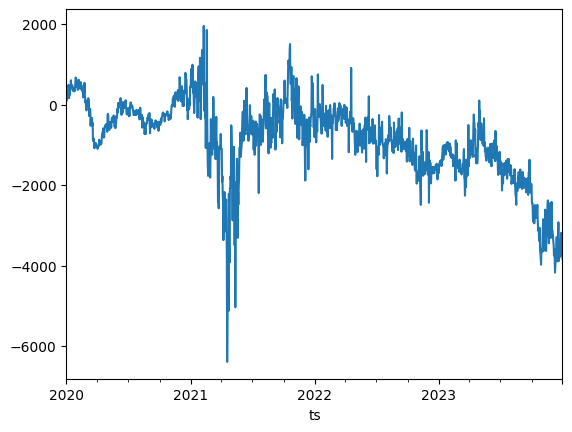

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

df = df1.join(df2, lsuffix='_binance', rsuffix='_upbit')
x = df["price_binance"] - df["price_upbit"]
x.plot()

# Calculate daily momentum

price_upbit_pct_change
False    1450
True       11
Name: count, dtype: int64 price_upbit_pct_change
False    1454
True        7
Name: count, dtype: int64


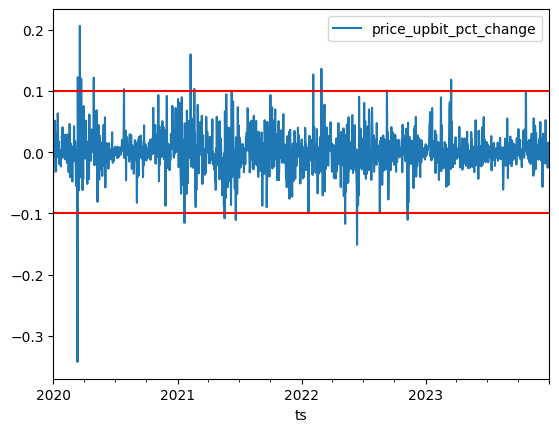

In [7]:
# Assuming that momentum X% and Y% is a daily pct change
df["price_upbit_pct_change"] = df["price_upbit"].pct_change(periods=1)
print((df["price_upbit_pct_change"] > 0.10).value_counts(), (df["price_upbit_pct_change"] < -0.10).value_counts())

df[["price_upbit_pct_change"]].plot()
plt.axhline(y=0.1, color='r', linestyle='-')
plt.axhline(y=-0.1, color='r', linestyle='-')


# Adjust data columns for backtesting api

In [8]:
df= df.rename(columns={"price_binance": "Close"})
df["Open"] = df["High"] = df["Low"] = df["Close"]
df.head()

,Close,Volume,price_upbit,price_upbit_pct_change,Open,High,Low
ts,,,,,,,
2020-01-01,7197.57,56801.329,7094.5,NaN,7197.57,7197.57,7197.57
2020-01-02,6962.04,115295.677,6863.5,-0.032560,6962.04,6962.04,6962.04
2020-01-03,7341.72,208493.458,7110.6,0.036002,7341.72,7341.72,7341.72
2020-01-04,7350.71,92586.033,7121.1,0.001477,7350.71,7350.71,7350.71
2020-01-05,7354.36,117765.972,7125.3,0.000590,7354.36,7354.36,7354.36


# Split data

In [9]:
import numpy as np

train_df, test_df = np.split(df, [df.shape[0] // 2], axis=0)
train_df.index[0], train_df.shape[0], test_df.index[0], test_df.shape[0]

(Timestamp('2020-01-01 00:00:00'), 730, Timestamp('2021-12-31 00:00:00'), 731)

# Implement stategy and test run

In [11]:
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy

from backtesting.test import SMA, GOOG

class KimchiStrat(SignalStrategy):
    x = 100
    y = 100

    def init(self):
        super().init()
        
        signalX = (pd.Series(self.data["price_upbit_pct_change"]) >= (self.x / 1000)).astype(int).diff().fillna(0)
        signalY = (pd.Series(self.data["price_upbit_pct_change"]) <= (-self.y / 1000)).astype(int).diff().fillna(0)
        signalX = signalX.replace(-1, 0)
        signalY = signalY.replace(-1, 0) * -1

        signal = signalX.add(signalY, fill_value=0)
        
        self.set_signal(entry_size=signal)


START_CASH = 100000
bt = Backtest(train_df, KimchiStrat, cash=START_CASH, exclusive_orders=True)

import warnings
warnings.filterwarnings('ignore')

output = bt.run(x=61, y=51) # 6.1% 5.1%
bt.plot()

GridPlot(id='p2773', ...)

# Optimize and heatmap

In [12]:
%%time
# range_params = range(1, 150, 1) ## Too heavy
range_params = range(10, 120, 10)
stats, heatmap = bt.optimize(
    x=range_params,
    y=range_params,
    maximize='Sharpe Ratio',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

heatmap.sort_values().iloc[-3:]

CPU times: user 105 ms, sys: 231 ms, total: 336 ms
Wall time: 1.42 s


x   y 
10  70    0.934334
40  70    1.013590
60  70    1.023104
Name: Sharpe Ratio, dtype: float64

In [13]:
from backtesting.lib import plot_heatmaps

plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p3488', ...)

# Optimize using decision trees

In [14]:
%%time
stats_skopt, heatmap, optimize_result = bt.optimize(
    x=[1, 150],
    y=[1, 150],
    maximize='Sharpe Ratio',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

heatmap.sort_values().iloc[-3:]

CPU times: user 44.3 s, sys: 2.06 s, total: 46.3 s
Wall time: 44.6 s


x   y 
66  52    1.077964
1   11    1.082685
    12    1.114540
Name: Sharpe Ratio, dtype: float64

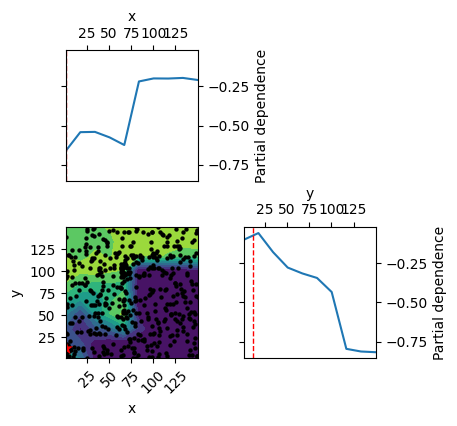

In [15]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

# Run forward testing

In [16]:
res_x, res_y = heatmap.sort_values().iloc[-1:].index.to_list()[0]

output = bt.run(x=res_x, y=res_y)
bt.plot()

GridPlot(id='p4141', ...)

# Results

In [17]:
print(f"X: {res_x/10}%, Y: -{res_y/10}%")

PERIOD = output["Duration"].days / 365
END_CASH=output["Equity Final [$]"]
CAGR = (END_CASH/START_CASH) ** (1/PERIOD) - 1

print(f"CAGR: {round(CAGR * 100, 2)}%") 

for i in ["Sharpe Ratio", "Max. Drawdown [%]", "Equity Final [$]", "Return (Ann.) [%]"]: 
    print(f"{i}: {output[i]}") 



X: 0.1%, Y: -1.2%
CAGR: 24.85%
Sharpe Ratio: 1.1145399325798113
Max. Drawdown [%]: -18.163445119319952
Equity Final [$]: 155790.30999999994
Return (Ann.) [%]: 24.815988559156963
